# Перцептрон для восприятия цифр
__Суммарное количество баллов: 10__

В этом задании вам предстоит реализовать классический перцептрон, немного улучшить его, и протестировать результат на классической задаче определния цифр по изображениям.

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs, make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn import datasets
import copy
from tqdm import tqdm
from sklearn.metrics import accuracy_score

SEED = 19

### Задание 1 (3 балла)
Для начала реализуем простой перцептрон.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [2]:
class Perceptron:
    def __init__(self, iterations=100, learning_rate=0.01, verbose=False, random_state=SEED):
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.w = None
        self.mapper = None
        self.verbose = verbose
        self.random_state = random_state
    
    def fit(self, X, y):
        np.random.seed(self.random_state)
        X = X.copy()
        # словарь для замены таргета на -1/1
        mapper = {np.unique(y)[i]: [-1, 1][i] for i in range(2)}
        # добавляем столбец для порогового значения
        X.insert(loc=0, column="intercept", value=1)
        # инициализируем веса стандартным нормальным распределением
        weights = np.random.randn(X.shape[1])
        for i in tqdm(range(self.iterations)) if self.verbose else range(self.iterations):
            try:
                i, x = next(examples)
            except (StopIteration, NameError):
                examples = X.iterrows()
                i, x = next(examples)
            y_pred = np.sign(x @ weights)
            y_true = mapper[y[i]]
            # если ошибки нет - идем дальше
            if y_pred == y_true:
                continue
            weights += (self.learning_rate * x * y_true).values
        self.mapper = mapper
        self.w = weights
            
    def predict(self, X):
        X = X.copy()
        X.insert(loc=0, column="intercept", value=1)
        y_pred = np.sign(X @ self.w).map({j: i for i, j in self.mapper.items()})
        return y_pred

In [3]:
def visualize(X, labels_true, labels_pred, w):
    unique_labels = np.unique(labels_true)
    unique_colors = dict([(l, c) for l, c in zip(unique_labels, [[0.8, 0., 0.], [0., 0., 0.8]])])
    plt.figure(figsize=(9, 9))

    if w[1] == 0:
        plt.plot([X[:, 0].min(), X[:, 0].max()], w[0] / w[2])
    elif w[2] == 0:
        plt.plot(w[0] / w[1], [X[:, 1].min(), X[:, 1].max()])  
    else:
        mins, maxs = X.min(axis=0), X.max(axis=0)
        pts = [[mins[0], -mins[0] * w[1] / w[2] - w[0] / w[2]],
               [maxs[0], -maxs[0] * w[1] / w[2] - w[0] / w[2]],
               [-mins[1] * w[2] / w[1] - w[0] / w[1], mins[1]],
               [-maxs[1] * w[2] / w[1] - w[0] / w[1], maxs[1]]]
        pts = [(x, y) for x, y in pts if mins[0] <= x <= maxs[0] and mins[1] <= y <= maxs[1]]
        x, y = list(zip(*pts))
        plt.plot(x, y, c=(0.75, 0.75, 0.75), linestyle="--")
    
    colors_inner = [unique_colors[l] for l in labels_true]
    colors_outer = [unique_colors[l] for l in labels_pred]
    plt.scatter(X[:, 0], X[:, 1], c=colors_inner, edgecolors=colors_outer)
    plt.show()

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

Accuracy: 0.94


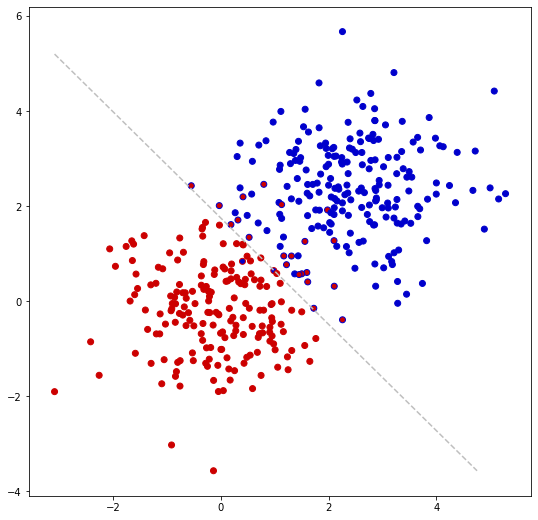

In [4]:
np.random.seed(SEED)
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
X = pd.DataFrame(X); true_labels = pd.Series(true_labels)
c = Perceptron(iterations=1000)
c.fit(X, true_labels)
pred_labels = np.array(c.predict(X))
print(f"Accuracy: {accuracy_score(true_labels, pred_labels)}")
visualize(X.values, true_labels.values, pred_labels, c.w)

Accuracy: 0.8725


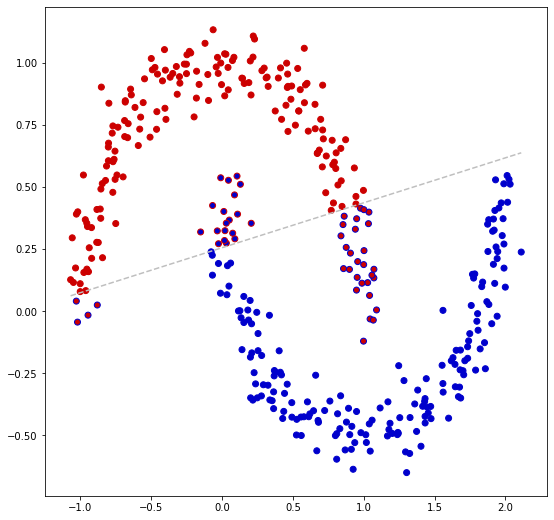

In [5]:
np.random.seed(SEED)
X, true_labels = make_moons(400, noise=0.075)
X = pd.DataFrame(X); true_labels = pd.Series(true_labels)
c = Perceptron(iterations=1000)
c.fit(X, true_labels)
pred_labels = np.array(c.predict(X))
print(f"Accuracy: {accuracy_score(true_labels, pred_labels)}")
visualize(X.values, true_labels.values, pred_labels, c.w)

### Задание 2 (2 балл)
Проблема обычной реализации перцептрона в том, что закончить его обучение мы можем с неоптимальными весами, т.к. точность разбиения в зависимости от числа итераций не растет монотонно. Чтобы этого избежать, мы можем оставлять в конце веса той итерации, на которой мы лучше всего разбивали множество `X`.

Реализуем перцептрон с карманом.

#### Методы
`predict(X)` - возвращает предсказанные метки для элементов выборки `X`

`fit(X, y)` - инициализирует веса перцептрона, а затем обновляет их в течении `iterations` итераций. В конце обучения оставляет лучшие веса. 

#### Параметры конструктора
`iterations` - количество итераций обучения перцептрона

#### Поля
`w` - веса перцептрона размерности `X.shape[1] + 1`. `w[0]` должен соответстовать константе, `w[1:]` - коэффициентам компонент элемента `X`.

In [6]:
class PerceptronBest:
    def __init__(self, iterations=100, learning_rate=0.01, score_fn=accuracy_score, verbose=False, random_state=SEED):
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.w = None
        self.mapper = None
        self.verbose = verbose
        self.score_fn = score_fn
        self.random_state = random_state
    
    def fit(self, X, y):
        np.random.seed(SEED)
        best = {"score": 0, "weghts": None}
        X = X.copy()
        mapper = {np.unique(y)[i]: [-1, 1][i] for i in range(2)}
        X.insert(loc=0, column="intercept", value=1)
        weights = np.random.randn(X.shape[1])
        for i in tqdm(range(self.iterations)) if self.verbose else range(self.iterations):
            try:
                i, x = next(examples)
            except (StopIteration, NameError):
                examples = X.iterrows()
                i, x = next(examples)
            y_pred = np.sign(x @ weights)
            y_true = mapper[y[i]]
            if y_pred == y_true:
                continue
            weights += (self.learning_rate * x * y_true).values
            y_pred_total = np.sign(X @ weights).map({j: i for i, j in mapper.items()})
            score = self.score_fn(y, y_pred_total)
            if score > best["score"]:
                best["score"] = score
                best["weights"] = weights
        self.mapper = mapper
        self.w = best["weights"]
            
    def predict(self, X):
        X = X.copy()
        X.insert(loc=0, column="intercept", value=1)
        y_pred = np.sign(X @ self.w).map({j: i for i, j in self.mapper.items()})
        return y_pred

Посмотрим на то, как наш перцептрон справляется с различными наборами данных

Accuracy: 0.94


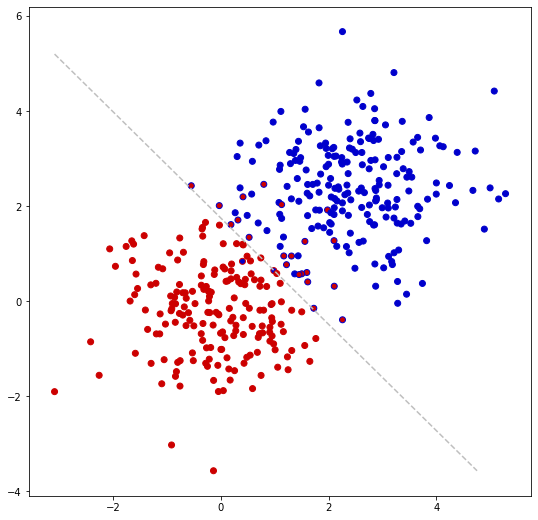

In [7]:
np.random.seed(SEED)
X, true_labels = make_blobs(400, 2, centers=[[0, 0], [2.5, 2.5]])
X = pd.DataFrame(X); true_labels = pd.Series(true_labels)
c = PerceptronBest(iterations=1000)
c.fit(X, true_labels)
pred_labels = np.array(c.predict(X))
print(f"Accuracy: {accuracy_score(true_labels, pred_labels)}")
visualize(X.values, true_labels.values, pred_labels, c.w)

Accuracy: 0.8725


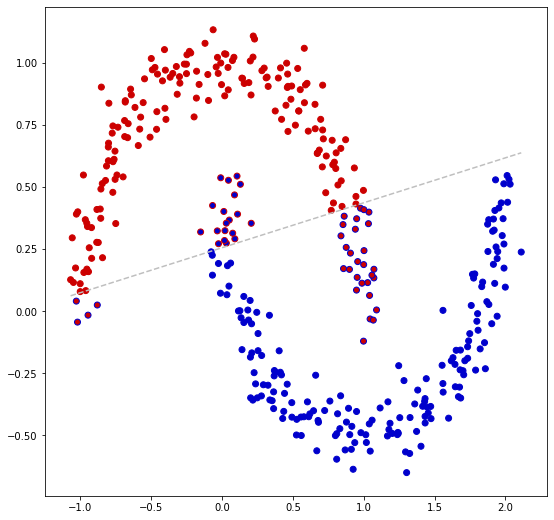

In [8]:
np.random.seed(SEED)
X, true_labels = make_moons(400, noise=0.075)
X = pd.DataFrame(X); true_labels = pd.Series(true_labels)
c = PerceptronBest(iterations=1000)
c.fit(X, true_labels)
pred_labels = np.array(c.predict(X))
print(f"Accuracy: {accuracy_score(true_labels, pred_labels)}")
visualize(X.values, true_labels.values, pred_labels, c.w)

### Задание 3 (1 балл)
Реализуйте метод `transform_images(images)`, который преобразует изображения в двумерные векторы. Значение компонент векторов придумайте сами и напишите в виде комментария к методу.

In [9]:
def transform_images(images):
    # суммируем пиксели по верхней и по нижней половинам изображения
    X = [[image[:4, :].sum(), image[4:, :].sum()] for image in images]
    return np.array(X)

def get_digits(y0=1, y1=5):
    data = datasets.load_digits()
    images, labels = data.images, data.target
    mask = np.logical_or(labels == y0, labels == y1)
    labels = labels[mask]
    images = images[mask]
    images /= np.max(images)
    X = transform_images(images)
    return X, labels

### Задание 4 (4 балла)
Теперь посмотрим на точность обычного перцептрона и перцептрона выбором лучшей итерации. Для тестирования будем использовать цифры 1 и 5. Необходимо использовать реализованное выше преобразование, т.е. только векторы из 2х признаков. 

Точность хотя бы одного из классификаторов на тестовой выборке должна быть больше 80%

In [10]:
X, y = get_digits()

X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), pd.Series(y), train_size=0.8, shuffle=False)

100%|██████████| 10000/10000 [00:01<00:00, 5714.83it/s]


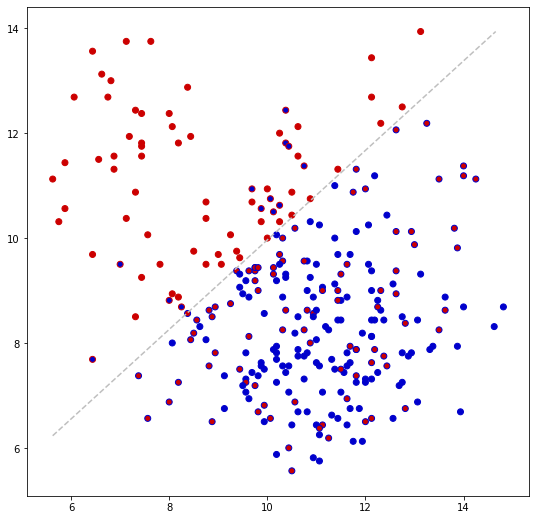

Accuracy: 0.6027397260273972


In [11]:
c = Perceptron(iterations=10000, verbose=True)
c.fit(X_train, y_train)
visualize(X_train.values, y_train.values, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

100%|██████████| 10000/10000 [00:06<00:00, 1532.40it/s]


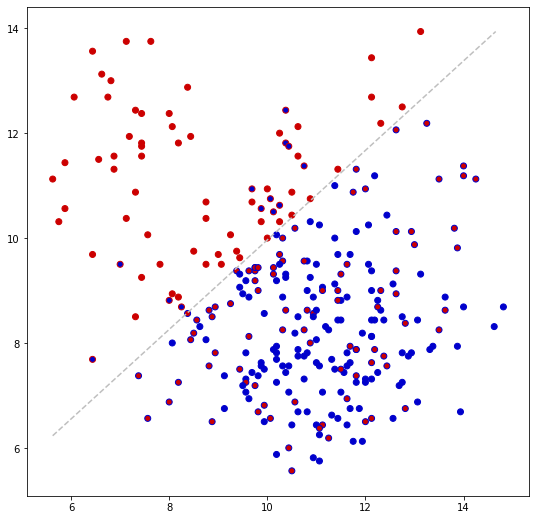

Accuracy: 0.6027397260273972


In [12]:
c = PerceptronBest(iterations=10000, verbose=True)
c.fit(X_train, y_train)
visualize(X_train.values, y_train.values, np.array(c.predict(X_train)), c.w)
print("Accuracy:", np.mean(c.predict(X_test) == y_test))

А теперь посчитаем среднюю точность по всем возможным парам цифр

In [13]:
accs = []
for y0, y1 in tqdm([(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]):
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), pd.Series(y), train_size=0.8, shuffle=False)
    c = Perceptron(iterations=10000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

100%|██████████| 45/45 [00:56<00:00,  1.26s/it]

Mean accuracy: 0.6955961798186379


In [14]:
accs = []
for y0, y1 in tqdm([(y0, y1) for y0 in range(9) for y1 in range(y0+1, 10)]):
    X, y = get_digits(y0, y1)
    X_train, X_test, y_train, y_test = train_test_split(pd.DataFrame(X), pd.Series(y), train_size=0.8, shuffle=False)
    c = PerceptronBest(iterations=10000)
    c.fit(X_train, y_train)
    accs.append(np.mean(c.predict(X_test) == y_test))
print("Mean accuracy:", np.mean(accs))

100%|██████████| 45/45 [03:33<00:00,  4.74s/it]

Mean accuracy: 0.6955961798186379
